In [3]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


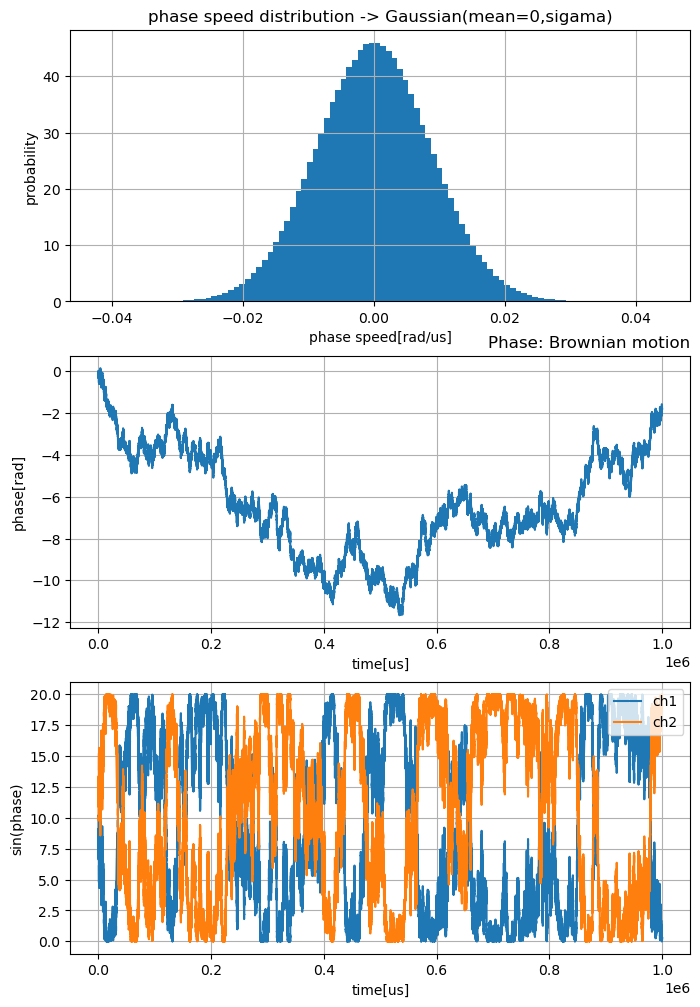

In [4]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi #rad/us
SIG_AMP=10 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [5]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())
    
def phase_to_dict(phase_measure_M4,phase_fb_M4,phase_measure_inter_M4,phase_fb_inter_M4,phase_M4):
    return dict(measure_quick=phase_measure_M4.tolist(),
                fb_quick=phase_fb_M4.tolist(),
                measure_inter=phase_measure_inter_M4.tolist(),
                fb_inter=phase_fb_inter_M4.tolist(),
                phase=phase_M4[:,-1].reshape(-1).tolist())

time_exposure=100 #us
kp,ki=1.11,3.51
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
sig_ch1_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量量ch1
sig_ch2_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量量ch2
phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量量
phase_measure_inter_M1=np.nan*np.zeros(phase_speed_M1.shape[0]) # 积分测量量
phase_fb_inter_M1=np.nan*np.zeros(phase_speed_M1.shape[0]) # 积分反馈量
phase_fb_M1=np.zeros(phase_speed_M1.shape[0]) # 反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0

for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    sig_ch1_measure_M1[i]=ch1_measure
    sig_ch2_measure_M1[i]=ch2_measure
    phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)        
    phase_fb_M1[i]=kp*phase_measure_M1[i]
    
    ##-- 反馈 
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_fb_M1[i]#/time_exposure # 反馈到下一个exposure
        ### 根据前time_inter*time_exposure项的积分去修正相位
        if i>0:
            phase_measure_inter_M1[i]=get_phase_from_count(sig_ch1_measure_M1[:i+1].sum(),sig_ch2_measure_M1[:i+1].sum())
            #phase_measure_inter_M1[i]=sig_ch1_measure_M1[:i+1].sum()-sig_ch2_measure_M1[:i+1].sum()
            phase_fb_inter_M1[i]=ki*phase_measure_inter_M1[i]
            phase_speed_M1[i+1,0]-=phase_fb_inter_M1[i]
            
            

    phase_offest=phase_M1[i,-1]
phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1,'phase M1')

100%|██████████| 10000/10000 [00:00<00:00, 74191.09it/s]

      phase speed     phase  phase M1
Mean    -0.000002 -6.359112  0.000119
Std      0.008713  2.486367  0.082157
Var      0.000076  6.182020  0.006750


### 改变权重

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_43998/3304720660.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_43998/3304720660.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_43998/3304720660.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Feedback weight: y=x when $x<a\sigma$ and \n y=a$\sigma+\Delta e^{-\Delta/b\si

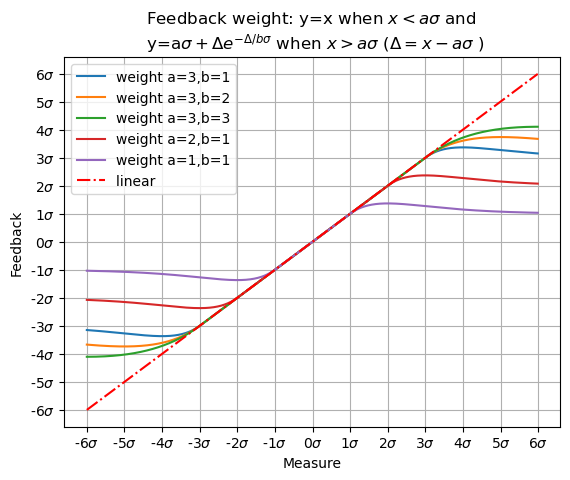

In [6]:
def fb_weight(measure, time_exposure,sigma=1,denominator=1):
    """denominator=1: 越大，权重越陡峭"""
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure/denominator))
    #weight=lambda x: np.sign(x) *(-(np.abs(x)/threshold-2)**2+2)*threshold
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    #split=0.314*phase_speed_in_measure
    #measure_filtered = np.where(np.abs(measure)<split, 0, measure_filtered)
    
    return measure_filtered

phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
x=np.arange(-2,2,1/256)*3*phase_speed_in_measure
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=3,denominator=1),label='weight a={},b={}'.format(3,1))
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=3,denominator=2),label='weight a={},b={}'.format(3,2))
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=3,denominator=3),label='weight a={},b={}'.format(3,3))
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=2,denominator=1),label='weight a={},b={}'.format(2,1))
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=1,denominator=1),label='weight a={},b={}'.format(1,1))
plt.plot(x,x,'r-.',label='linear ')
plt.legend()
plt.grid()
plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.xlabel('Measure')
plt.ylabel('Feedback')
plt.title('Feedback weight: y=x when $x<a\sigma$ and \n y=a$\sigma+\Delta e^{-\Delta/b\sigma}$ when $x>a\sigma$ ($\Delta =x-a\sigma$ )')
plt.show()

In [7]:
time_exposure=2 #us
time_inter=2
dirc_inter=10
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M4=np.zeros_like(phase_speed_M4)
sig_ch1_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch1
sig_ch2_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch2
phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
phase_measure_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分测量量
phase_fb_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分反馈量
phase_fb_dirc_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 方向反馈量
phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
fb0=0
sigma=1
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    sig_ch1_measure_M4[i]=ch1_measure
    sig_ch2_measure_M4[i]=ch2_measure
    phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
    c0=phase_measure_M4[i]
    
    phase_fb_M4[i]=fb_weight(c0,time_exposure=time_exposure,sigma=1.2)
    


    ##-- 反馈 
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure
        ### 根据前六项的积分去修正相位
        # if  i%time_inter==0 and i>=time_inter:
        #     phase_measure_inter_M4[i]=get_phase_from_count(sig_ch1_measure_M4[i-time_inter:i+1].sum(),sig_ch2_measure_M4[i-time_inter:i+1].sum())
        #     phase_fb_inter_M4[i]=fb_weight(phase_measure_inter_M4[i],time_exposure=time_inter*time_exposure,sigma=2,denominator=1)
        #     phase_speed_M4[i+1,0]-=phase_fb_inter_M4[i]
        ### 根据前六项的方向去修正相位
        # if  i>=9 and i%dirc_inter==0:
        #     inter=np.sign(np.sum(np.sign(phase_measure_M4[i-dirc_inter:i+1])))
        #     phase_fb_dirc_M4[i]=inter*PHASE_SEEPD#*np.sqrt(time_exposure*dirc_inter)
        #     phase_speed_M4[i+1,0]-=phase_fb_dirc_M4[i]

    phase_offest=phase_M4[i,-1]
phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
push_data(phase_out_M4,'phase M4 origin')
m4_orgin=phase_to_dict(phase_measure_M4,phase_fb_M4,
                       phase_measure_inter_M4,phase_fb_inter_M4,
                       phase_M4)

100%|██████████| 500000/500000 [00:05<00:00, 83597.63it/s]

      phase speed     phase  phase M1  phase M4 origin
Mean    -0.000002 -6.359112  0.000119        -0.000754
Std      0.008713  2.486367  0.082157         0.051540
Var      0.000076  6.182020  0.006750         0.002656


Text(0, 0.5, 'Phase [rad]')

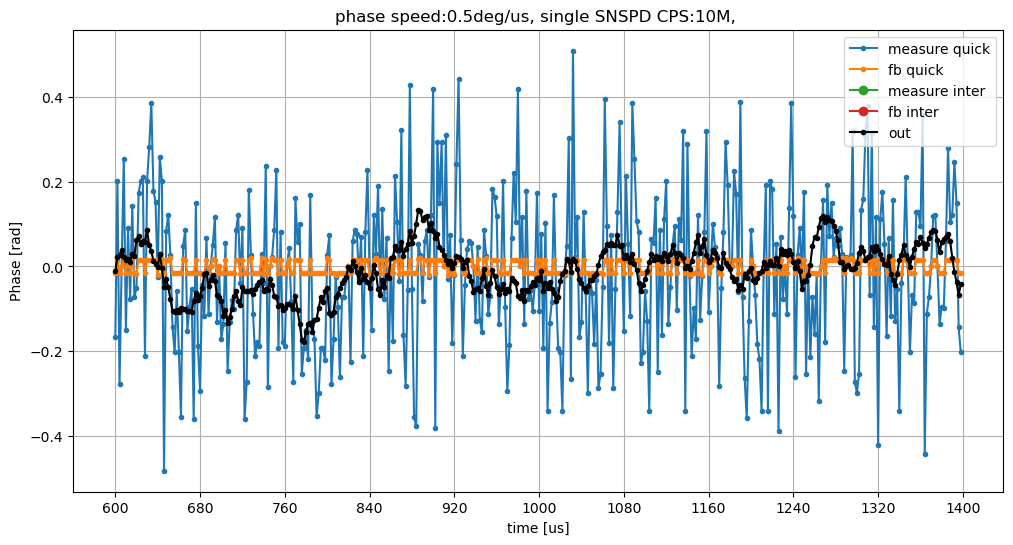

In [8]:
x0=300
x1=700
graph_dict=m4_orgin
plt.figure(figsize=(12,6))
plt.plot(graph_dict['measure_quick'][x0:x1],'.-',label='measure quick')
plt.plot(graph_dict['fb_quick'][x0:x1],'.-',label='fb quick')
plt.plot(graph_dict['measure_inter'][x0:x1],'o-',label='measure inter')
plt.plot(graph_dict['fb_inter'][x0:x1],'o-',label='fb inter')
plt.plot(graph_dict['phase'][x0:x1],'.-k',label='out')
plt.xticks(np.arange(0,x1-x0+1,(x1-x0)//10),labels=np.arange(x0,x1+1,(x1-x0)//10)*time_exposure)
plt.legend(loc=1)
plt.grid()
plt.title('phase speed:{}deg/us, single SNSPD CPS:{}M, '.format(PHASE_SEEPD/np.pi*180,SIG_AMP))
plt.xlabel('time [us]')
plt.ylabel('Phase [rad]')
#plt.ylim([-1,1])

## PI_feedback  
$$
u_{k}=K_{p}Estimate(M_{k},a,b)+K_{i}Estimate(\sum_{i=1}^{k}M_{i},a,b)
$$  
其中$u_{k}$是反馈量,$K_{p}$和$K_{i}$是比例和积分增益,Estimate是估计函数,M_{k}是当前测量值,a和b是权重函数的系数.

In [9]:
time_exposure=2 #us
def simu_pi(phase_speed,time_exposure=2,time_inter=20,kp=1,ap=1,bp=1,ki=1,ai=1,bi=1):
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M4=np.zeros_like(phase_speed_M4)
    sig_ch1_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch1
    sig_ch2_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch2
    phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
    phase_measure_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分测量量
    phase_fb_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分反馈量
    phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        sig_ch1_measure_M4[i]=ch1_measure
        sig_ch2_measure_M4[i]=ch2_measure
        phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)        
        phase_fb_M4[i]=kp*fb_weight(phase_measure_M4[i],time_exposure=time_exposure,
                                    sigma=ap,denominator=bp)
        
        ##-- 反馈 
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure
            ### 根据前time_inter*time_exposure项的积分去修正相位
            if i>=100:
                phase_measure_inter_M4[i]=get_phase_from_count(sig_ch1_measure_M4[i-time_inter:i+1].sum(),sig_ch2_measure_M4[i-time_inter:i+1].sum())
                phase_fb_inter_M4[i]=ki*fb_weight(phase_measure_inter_M4[i],time_exposure=time_inter*time_exposure,
                                                  sigma=ai,denominator=bi)
                phase_speed_M4[i+1,0]-=phase_fb_inter_M4[i]
                
                

        phase_offest=phase_M4[i,-1]
    phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
    #push_data(phase_out_M4,'phase M4 intergration')
    data_dict=phase_to_dict(phase_measure_M4,phase_fb_M4,
                        phase_measure_inter_M4,phase_fb_inter_M4,
                        phase_M4)
    return phase_out_M4,data_dict

phase_out,m4_p1i0=simu_pi(phase_speed=phase_speed,time_exposure=2,time_inter=20,kp=1,ki=0)
push_data(phase_out,'phase M4 p1i0')

100%|██████████| 500000/500000 [00:09<00:00, 52512.21it/s]

      phase speed     phase  phase M1  phase M4 origin  phase M4 p1i0
Mean    -0.000002 -6.359112  0.000119        -0.000754      -0.000475
Std      0.008713  2.486367  0.082157         0.051540       0.051421
Var      0.000076  6.182020  0.006750         0.002656       0.002644


In [14]:
def simu_pi_2i(phase_speed,time_exposure=2,time_inter=20,time_inter2=46,kp=1,ap=1,bp=1,ki=1,ai=1,bi=1,ki2=1,ai2=1,bi2=1):
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M4=np.zeros_like(phase_speed_M4)
    sig_ch1_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch1
    sig_ch2_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch2
    phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
    phase_measure_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分测量量
    phase_fb_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分反馈量
    phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
    phase_measure_inter2_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分测量量2
    phase_fb_inter2_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分反馈量2
    
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        sig_ch1_measure_M4[i]=ch1_measure
        sig_ch2_measure_M4[i]=ch2_measure
        phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)        
        phase_fb_M4[i]=kp*fb_weight(phase_measure_M4[i],time_exposure=time_exposure,
                                    sigma=ap,denominator=bp)
        
        ##-- 反馈 
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure
            ### 根据前time_inter*time_exposure项的积分去修正相位
            if i>=100:
                phase_measure_inter_M4[i]=get_phase_from_count(sig_ch1_measure_M4[i-time_inter:i+1].sum(),sig_ch2_measure_M4[i-time_inter:i+1].sum())
                phase_fb_inter_M4[i]=ki*fb_weight(phase_measure_inter_M4[i],time_exposure=time_inter*time_exposure,
                                                  sigma=ai,denominator=bi)
                phase_speed_M4[i+1,0]-=phase_fb_inter_M4[i]
                
                phase_measure_inter2_M4[i]=get_phase_from_count(sig_ch1_measure_M4[i-time_inter2:i+1].sum(),sig_ch2_measure_M4[i-time_inter2:i+1].sum())
                phase_fb_inter2_M4[i]=ki2*fb_weight(phase_measure_inter2_M4[i],time_exposure=time_inter2*time_exposure,
                                                  sigma=ai2,denominator=bi2)
                phase_speed_M4[i+1,0]-=phase_fb_inter2_M4[i]
                
                

        phase_offest=phase_M4[i,-1]
    phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
    #push_data(phase_out_M4,'phase M4 intergration')
    data_dict=phase_to_dict(phase_measure_M4,phase_fb_M4,
                        phase_measure_inter_M4,phase_fb_inter_M4,
                        phase_M4)
    data_dict['measure_inter2']=phase_measure_inter2_M4.tolist()
    data_dict['fb_inter2']=phase_fb_inter2_M4.tolist()
    return phase_out_M4,data_dict

phase_out_i2,m4_p1i1i2=simu_pi_2i(phase_speed=phase_speed,time_exposure=2,time_inter=2,time_inter2=200,
                               kp=0.3,ap=2.5,bp=0.6,
                               ki=0.4,ai=1.5,bi=1.6,
                               ki2=0.5,ai2=3,bi2=1.6)

push_data(phase_out_i2,'phase M4 p1i1i1')

100%|██████████| 500000/500000 [00:12<00:00, 40285.19it/s]


      phase speed     phase  phase M1  phase M4 origin  phase M4 p1i0  \
Mean    -0.000002 -6.359112  0.000119        -0.000754      -0.000475   
Std      0.008713  2.486367  0.082157         0.051540       0.051421   
Var      0.000076  6.182020  0.006750         0.002656       0.002644   

      phase M4 p1i1i1  
Mean        -0.000024  
Std          0.057337  
Var          0.003288  


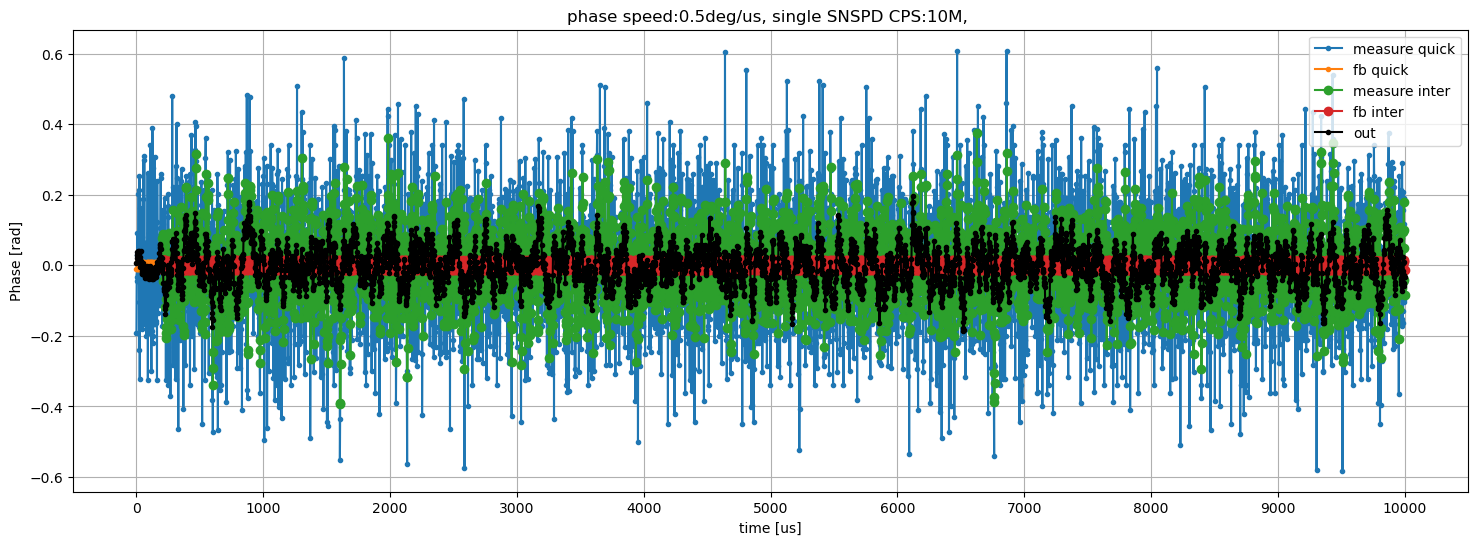

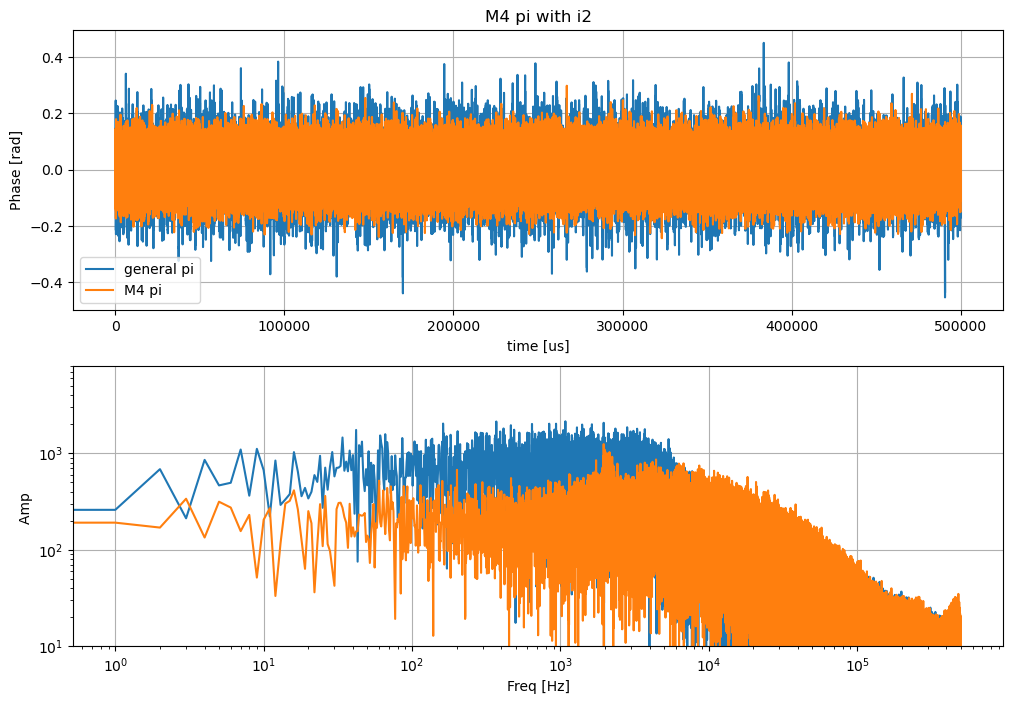

In [ ]:
# x0=0
# x1=600
def plot_fb(graph_dict,x0=0,x1=300):
    plt.figure(figsize=(18,6))
    plt.plot(graph_dict['measure_quick'][x0:x1],'.-',label='measure quick')
    plt.plot(graph_dict['fb_quick'][x0:x1],'.-',label='fb quick')
    plt.plot(graph_dict['measure_inter'][x0:x1],'o-',label='measure inter')
    plt.plot(graph_dict['fb_inter'][x0:x1],'o-',label='fb inter')
    plt.plot(graph_dict['phase'][x0:x1],'.-k',label='out')
    plt.xticks(np.arange(0,x1-x0+1,(x1-x0)//10),labels=np.arange(x0,x1+1,(x1-x0)//10)*time_exposure)
    plt.legend(loc=1)
    plt.grid()
    plt.title('phase speed:{}deg/us, single SNSPD CPS:{}M, '.format(PHASE_SEEPD/np.pi*180,SIG_AMP))
    plt.xlabel('time [us]')
    plt.ylabel('Phase [rad]')
    plt.show()
# plot_fb(m4_p1i1i2,x0=0,x1=5000)

# freq=np.fft.rfftfreq(phase_out_i2.size,d=1e-6)
# phase_fft=np.fft.rfft(phase_out_i2)
# plt.figure(figsize=(12,4))
# plt.loglog(freq,np.abs(phase_fft))
# plt.grid()

text='M4 pi with i2'
x0=0
x1=10000000
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(phase_out_M1[1::2][x0:x1],label='general pi')
plt.plot(phase_out_i2[1::2][x0:x1],label='M4 pi')
plt.legend()
plt.title(text)
plt.ylabel('Phase [rad]')
plt.xlabel('time [us]')
plt.grid()

freq=np.fft.rfftfreq(phase_out_i2.size,d=1e-6)
phase_fft=np.fft.rfft(phase_out_i2)
phase_g_fft=np.fft.rfft(phase_out_M1)
plt.subplot(212)
plt.loglog(freq,np.abs(phase_g_fft),label='general pi')
plt.loglog(freq,np.abs(phase_fft),label='M4 pi')
plt.ylabel('Amp ')
plt.xlabel('Freq [Hz]')
plt.ylim(1e1,8e3)
plt.grid()

In [13]:
import optuna 
def objective_p1i0(trial):
    kp = trial.suggest_float("Kp", 0.1, 3,step=0.2)
    ap = trial.suggest_float("ap", 0.5, 3,step=0.5)
    bp = trial.suggest_float("bp", 0.1, 3,step=0.5)
    
    phase_out,data_dict=simu_pi(phase_speed=phase_speed,time_exposure=2,time_inter=20,
                        kp=kp,ap=ap,bp=bp,
                        ki=0,ai=1,bi=1)
    #trial.set_user_attr("data", data_dict)
    return np.var(phase_out)


def objective_p1i1(trial):
    kp = trial.suggest_float("Kp", 0.1, 3,step=0.2)
    ap = trial.suggest_float("ap", 0.5, 3,step=0.5)
    bp = trial.suggest_float("bp", 0.1, 3,step=0.5)
    ki = trial.suggest_float("Ki", 0,   1,step=0.01)
    if ki!=0:
        ai = trial.suggest_float("ai", 0.5, 3,step=0.5)
        bi = trial.suggest_float("bi", 0.1, 3,step=0.5)
    
    phase_out,data_dict=simu_pi(phase_speed=phase_speed,time_exposure=2,time_inter=20,
                        kp=kp,ap=ap,bp=bp,
                        ki=ki,ai=ai,bi=bi)
    #trial.set_user_attr("data", data_dict)
    return np.var(phase_out)


In [14]:
study = optuna.create_study(storage='sqlite:///data/m4_p1i1.db',study_name='m4_p1i1',load_if_exists=True)
#study.optimize(objective_p1i1, n_trials=1000)


[I 2025-10-20 21:28:57,538] Using an existing study with name 'm4_p1i1' instead of creating a new one.


In [15]:
study.best_params

{'Kp': 0.30000000000000004,
 'ap': 2.5,
 'bp': 0.6,
 'Ki': 0.04,
 'ai': 0.5,
 'bi': 1.6}

100%|██████████| 500000/500000 [00:10<00:00, 48796.58it/s]


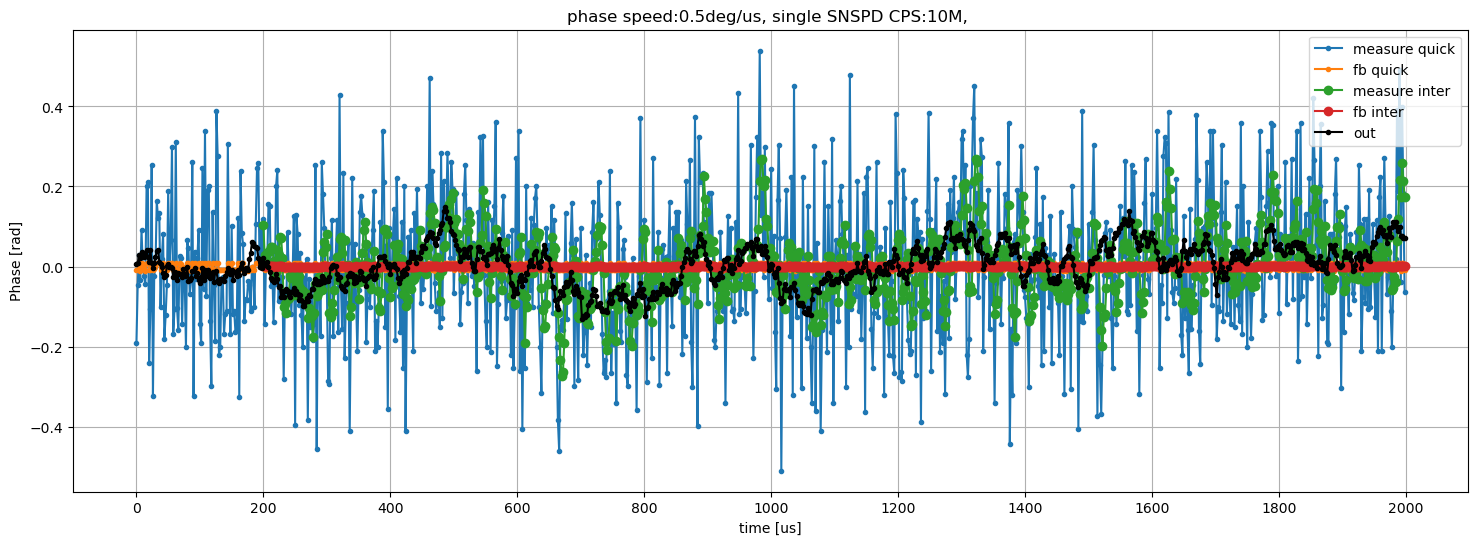

In [16]:
kp = 0.3
ap = 2.5
bp = 0.6
ki=0.04
ai=0.5
bi=1.6
phase_out,data_dict_I=simu_pi(phase_speed=phase_speed,time_exposure=2,time_inter=4,
                    kp=kp,ap=ap,bp=bp,
                    ki=ki,ai=ai,bi=bi)
plot_fb(data_dict_I,x0=0,x1=1000)

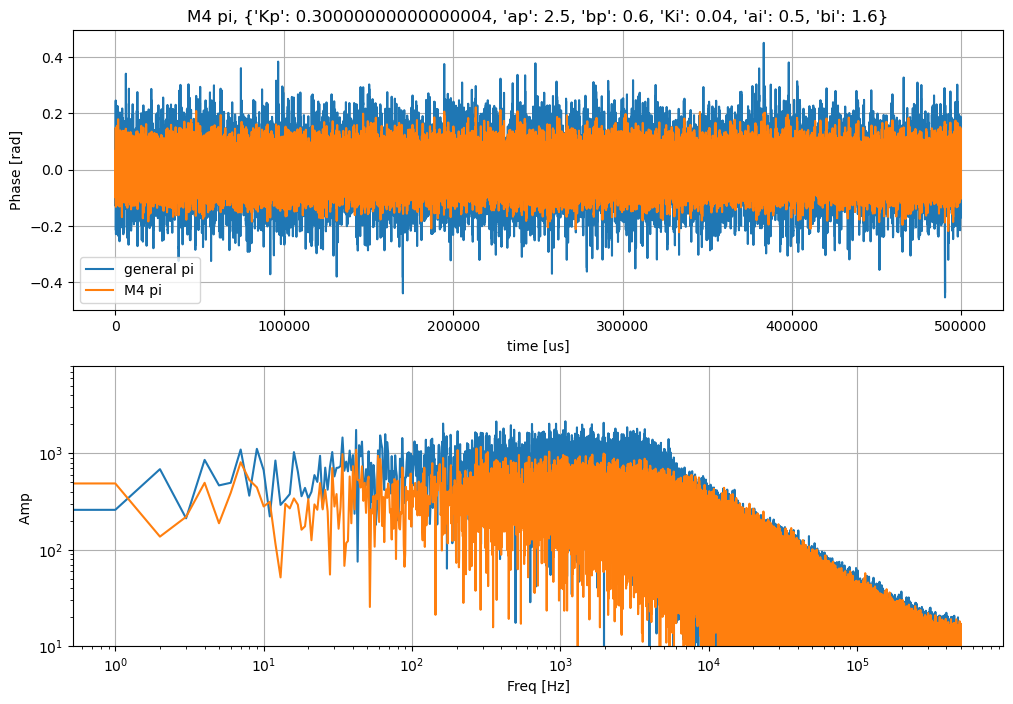

In [17]:
text='M4 pi, '+str(study.best_params)
x0=0
x1=10000000
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(phase_out_M1[1::2][x0:x1],label='general pi')
plt.plot(phase_out[1::2][x0:x1],label='M4 pi')
plt.legend()
plt.title(text)
plt.ylabel('Phase [rad]')
plt.xlabel('time [us]')
plt.grid()

freq=np.fft.rfftfreq(phase_out.size,d=1e-6)
phase_fft=np.fft.rfft(phase_out)
phase_g_fft=np.fft.rfft(phase_out_M1)
plt.subplot(212)
plt.loglog(freq,np.abs(phase_g_fft),label='general pi')
plt.loglog(freq,np.abs(phase_fft),label='M4 pi')
plt.ylabel('Amp ')
plt.xlabel('Freq [Hz]')
plt.ylim(1e1,8e3)
plt.grid()

100%|██████████| 500000/500000 [00:26<00:00, 19070.17it/s]


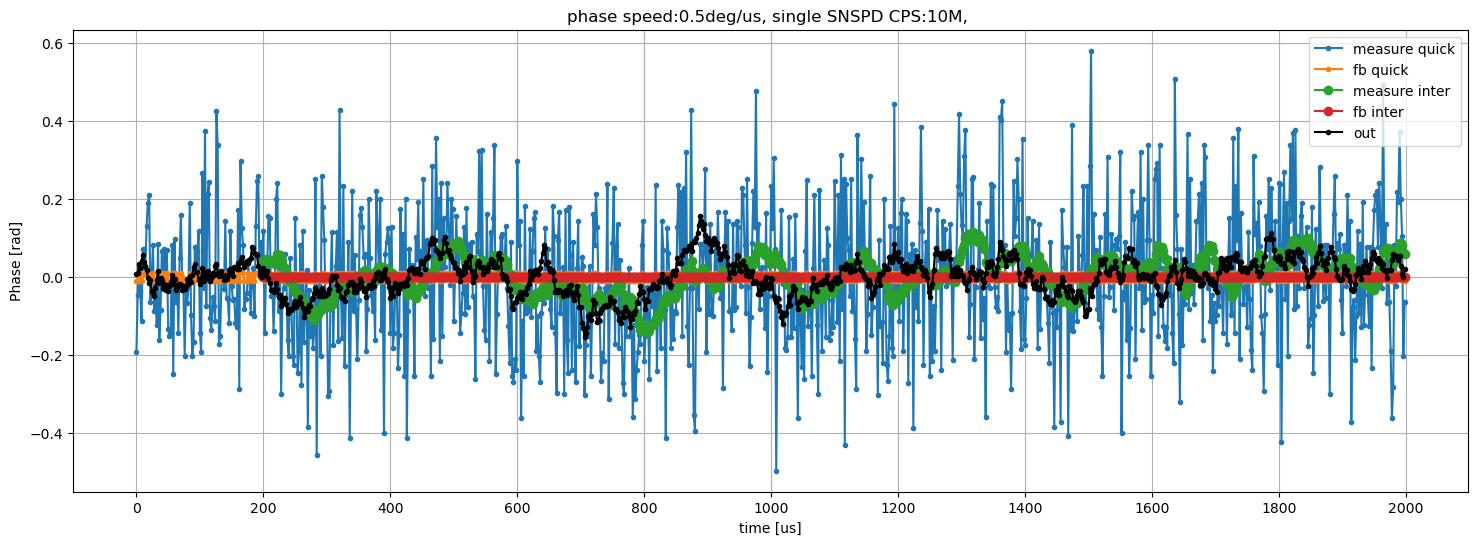

In [ ]:
kp = 0.3
ap = 3.0
bp = 0.1
ki=0.0
ai=1
bi=1
phase_out,data_dict=simu_pi(phase_speed=phase_speed,time_exposure=2,time_inter=20,
                    kp=kp,ap=ap,bp=bp,
                    ki=ki,ai=ai,bi=bi)
plot_fb(data_dict,x0=0,x1=1000)

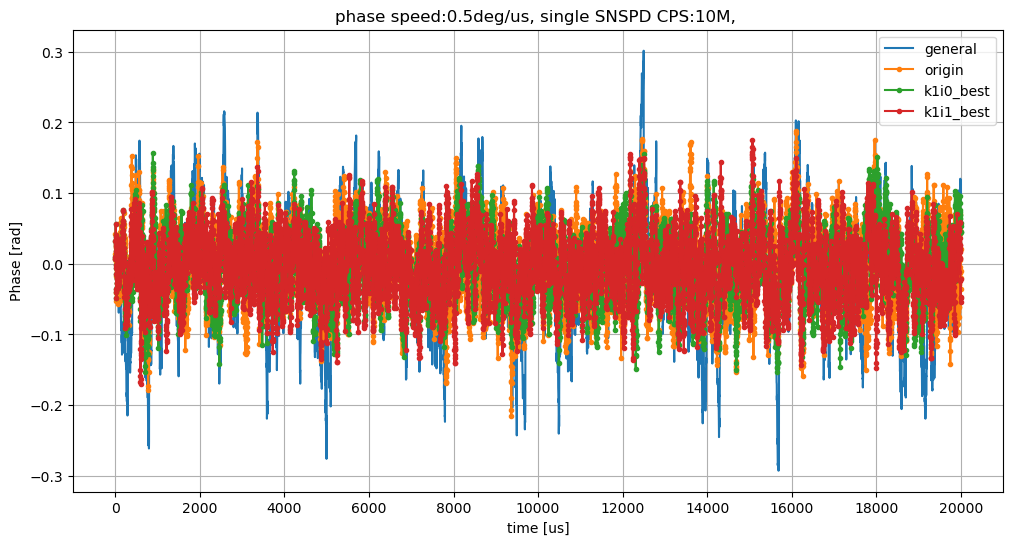

In [ ]:
x0=0
x1=10000
plt.figure(figsize=(12,6))
plt.plot(phase_out_M1[1::2][x0:x1],label='general')
plt.plot(m4_orgin['phase'][x0:x1],'.-',label='origin')
plt.plot(data_dict['phase'][x0:x1],'.-',label='k1i0_best')
plt.plot(data_dict_I['phase'][x0:x1],'.-',label='k1i1_best')
plt.xticks(np.arange(0,x1-x0+1,(x1-x0)//10),labels=np.arange(x0,x1+1,(x1-x0)//10)*time_exposure)
plt.legend(loc=1)
plt.grid()
plt.title('phase speed:{}deg/us, single SNSPD CPS:{}M, '.format(PHASE_SEEPD/np.pi*180,SIG_AMP))
plt.xlabel('time [us]')
plt.ylabel('Phase [rad]')
plt.show()